# Chicago Homicide Density Estimation
Spring 2019 AME-70790 Final Project

Nicholas Geneva (ngeneva@nd.edu)

Reference: Wand, M. P., & Jones, M. C. (1994). Kernel smoothing. Chapman and Hall/CRC.
___
Let us consider a practical application of using a KDE to extract useful information from some given data.
For this example we will take a look at the homicides that have occurred in Chicago from 2001 to present date.
This data as well as other crime statistics are publicly available from the city of [Chicago Data Portal](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present-Dashboard).
Here we are particularly interested in the location of the homicides as we would like to build a density map to show where potentially dangerous areas are. *Note* that the locations of the homicide have been slightly shifted at random to protect the privacy of those involved.

Since the full crime data set is rather large, we have already filtered the crimes to just homicides and have also preprocessed the data into a numpy array that contains the year, longitude and latitude of each crimes.

In [114]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

In [17]:
plt.close("all")
np.random.seed(123)

# Load data and create pandas datafram
data = np.load('data/chicago_homicide_data.npy')
dataset = pd.DataFrame({'Year':data[:,0].astype(int),'Longitude':data[:,1],'Latitude':data[:,2]})
with pd.option_context('display.max_rows',7):
    display(dataset)

,Year,Longitude,Latitude
0,2001,-91.686566,36.619446
1,2003,-91.686566,36.619446
2,2003,-91.686566,36.619446
...,...,...,...
9615,2019,-87.587182,41.764227
9616,2019,-87.709072,41.782520
9617,2019,-87.623952,41.687125


Thats almost 10 times the amount of data we have used compared the previous examples, thus for our KDE we mini-batch the data.
Similar to the previous example we will use a multivariate Gaussian kernel:
    $$K(\textbf{x})=\mathcal{N}(\textbf{x}|0,H), \quad H=\left[\begin{matrix} 10^{-5} & 0 \\ 0 & 10^{-5} \end{matrix}\right].$$
This may take a bit to run.

In [75]:
# Create grid, longitude and latidue limits are determined from map overlay used
n = 200
longitude = np.linspace(-88, -87, n)
latitude = np.linspace(41.5, 42.2, n)
X0, Y0 = np.meshgrid(longitude, latitude)
X = np.stack([np.reshape(X0, (-1)), np.reshape(Y0, (-1))], axis=1)

# Kernel covariance
H = np.array([[1e-5,0],[0,1e-5]])
y_pred = np.zeros(X.shape[0])

# Mini-batch our training data in sets of 500
batch_size = 500
n_minibatches = data.shape[0] // batch_size
for i in range(n_minibatches + 1):
    x_train0 = dataset.iloc[i * batch_size:(i + 1)*batch_size, 1:]
    
    # Expand array dims and repeat
    x_pred = np.expand_dims(X, axis=1).repeat(x_train0.shape[0], axis=1)
    x_train = np.expand_dims(x_train0, axis=0).repeat(X.shape[0], axis=0)
    
    y_pred[:] = y_pred[:] + (1./dataset.shape[0])*np.sum(multivariate_normal.pdf(x_pred-x_train, cov=H), axis=-1)

Now all what we have left is to plot the results.
To make the predictions more interpretable we will overlay a map of Chicago obtained from the [Open Street Map](http://openstreetmap.org) project.
The longitude and latitude of the map was determined when cropping the image.

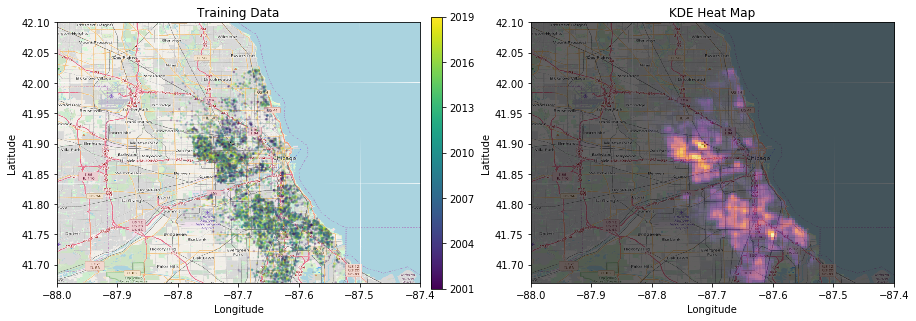

In [129]:
plt.close('all')
fig = plt.figure(figsize=(15,5))
ax = []
ax.append(plt.subplot2grid((1, 9), (0, 0), colspan=4))
ax.append(plt.subplot2grid((1, 9), (0, 5), colspan=4))

# Draw map on plots
chicago_map = plt.imread('data/chicago-map.png')
ax[0].imshow(chicago_map, extent=[-88, -87.3333, 41.6666, 42.1666])
ax[1].imshow(chicago_map, extent=[-88, -87.3333, 41.6666, 42.1666])

# Plot data points and color them based on year commited
colors = dataset.iloc[:,0]
sc = ax[0].scatter(dataset.iloc[:,1], dataset.iloc[:,2], c=colors, marker='o', s=2.0, alpha=0.2)
p0 = ax[0].get_position().get_points().flatten()
cax = fig.add_axes([p0[2]+0.08, p0[1], 0.010, p0[3]-p0[1]])
tickLabels = np.arange(2001, 2019+1e-8, 3).astype(int)
ticks = np.linspace(0,1,tickLabels.shape[0])
cbar = mpl.colorbar.ColorbarBase(cax, orientation='vertical', ticks=ticks)
cbar.set_ticklabels(tickLabels)

# Plot target densities
x = np.reshape(X[:,0], (n,n))
y = np.reshape(X[:,1], (n,n))
y_pred = np.reshape(y_pred, (n,n))
CS = ax[1].imshow(y_pred, cmap='inferno', alpha=0.6, extent=[-88, -87, 41.5, 42.2], origin='lower')

for ax0 in ax:
    ax0.set_xlim([-88, -87.4])
    ax0.set_ylim([41.67, 42.1])
    ax0.set_xlabel('Longitude')
    ax0.set_ylabel('Latitude')

ax[0].set_title('Training Data')
ax[1].set_title('KDE Heat Map')
plt.show()

Granted we can see the density relatively by just plotting the data, the KDE gives a much more concrete illustration of where crimes are occurring.
We largely don't see many crimes in the central part of Chicago (where all the tourists are) which largely makes sense given the region.
As expected we  see the majority of the crimes occurring on the West and South sides on the outskirts of the city which tend to be hot spots for gang violence.
These results are comparable to the crime summary map provided by the [Chicago police](http://gis.chicagopolice.org/CLEARMap_crime_sums/startPage.htm).